# <center> Лабораторная работа №4
## <center> "Подготовка обучающей и тестовой выборки, кросс-валидация и подбор гиперпараметров на примере метода ближайших соседей"

**Цель лабораторной работы:** изучение сложных способов подготовки выборки и подбора гиперпараметров на примере метода ближайших соседей.

  Для обработки пропусков в числовых данных будем использовать набор данных об автомобилях. Набор данных состоит из спецификации автомобилей с описанием различных технических параметров, а также одного неопределенного параметра origin.

Задача регрессии состоит в предсказании расхода топлива автомобиля на основании других параметров.

Колонки:

 - `cylinders` - кол-во цилиндров в двигателе
 - `displacement` - рабочий объем двигателя
 - `horsepower` - кол-во лошадиных сил
 - `weight` - вес автомобиля
 - `acceleration` - ускорение. кол-во секунд, за которое автомобиль с места достигает скорости в 60 миль/час (~100км/час)
 - `model_year` - год выпуска автомобиля (19xx год)
 - `origin` - неизвестный параметр (его удалим в самом начале работы)
 - `car_name` - название автомобиля
 - `mpg` - расход топлива в милях на американский галлон (miles/gallon)

In [49]:
import numpy as np
import pandas as pd
pd.set_option('display.max.columns', 100)
# to draw pictures in jupyter notebook
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns
# we don't like warnings
# you can comment the following 2 lines if you'd like to
import warnings
warnings.filterwarnings('ignore')

sns.set(style="whitegrid")

In [2]:
# Таблица данных
data = pd.read_csv('../Dataset/auto_mpg_dataset.csv', sep = ',')
data

,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name,mpg
0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu,18.0
1,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320,15.0
2,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite,18.0
3,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst,16.0
4,8,302.0,140.0,3449.0,10.5,70,1,ford torino,17.0
...,...,...,...,...,...,...,...,...,...
393,4,140.0,86.0,2790.0,15.6,82,1,ford mustang gl,27.0
394,4,97.0,52.0,2130.0,24.6,82,2,vw pickup,44.0
395,4,135.0,84.0,2295.0,11.6,82,1,dodge rampage,32.0
396,4,120.0,79.0,2625.0,18.6,82,1,ford ranger,28.0


In [3]:
# Удалим непонятный для нас параметр, чтобы он не помешал в будущем
data = data.drop(columns='origin')
data

,cylinders,displacement,horsepower,weight,acceleration,model_year,car_name,mpg
0,8,307.0,130.0,3504.0,12.0,70,chevrolet chevelle malibu,18.0
1,8,350.0,165.0,3693.0,11.5,70,buick skylark 320,15.0
2,8,318.0,150.0,3436.0,11.0,70,plymouth satellite,18.0
3,8,304.0,150.0,3433.0,12.0,70,amc rebel sst,16.0
4,8,302.0,140.0,3449.0,10.5,70,ford torino,17.0
...,...,...,...,...,...,...,...,...
393,4,140.0,86.0,2790.0,15.6,82,ford mustang gl,27.0
394,4,97.0,52.0,2130.0,24.6,82,vw pickup,44.0
395,4,135.0,84.0,2295.0,11.6,82,dodge rampage,32.0
396,4,120.0,79.0,2625.0,18.6,82,ford ranger,28.0


In [4]:
# Размер набора данных
data.shape

(398, 8)

In [5]:
# Типы данных в колонках
data.dtypes

cylinders         int64
displacement    float64
horsepower      float64
weight          float64
acceleration    float64
model_year        int64
car_name         object
mpg             float64
dtype: object

### Проверка на наличие пропущенных значений

In [6]:
data.isnull().sum()

cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
model_year      0
car_name        0
mpg             0
dtype: int64

Пропущенных значений нет

### Основные статистические показатели набора данных

In [7]:
data.describe()

,cylinders,displacement,horsepower,weight,acceleration,model_year,mpg
count,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000
mean,5.454774,193.425879,-1404.643216,2970.424623,15.568090,76.010050,23.514573
std,1.701004,104.269838,12213.424763,846.841774,2.757689,3.697627,7.815984
min,3.000000,68.000000,-100000.000000,1613.000000,8.000000,70.000000,9.000000
25%,4.000000,104.250000,75.000000,2223.750000,13.825000,73.000000,17.500000
50%,4.000000,148.500000,92.000000,2803.500000,15.500000,76.000000,23.000000
75%,8.000000,262.000000,125.000000,3608.000000,17.175000,79.000000,29.000000
max,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,46.600000


Из этих данных можно увидеть, что праметр "horsepower" имеет отрицательные значения - что не допустимо
Удалим эти строки

In [8]:
data = data[data.horsepower > 0]
data

,cylinders,displacement,horsepower,weight,acceleration,model_year,car_name,mpg
0,8,307.0,130.0,3504.0,12.0,70,chevrolet chevelle malibu,18.0
1,8,350.0,165.0,3693.0,11.5,70,buick skylark 320,15.0
2,8,318.0,150.0,3436.0,11.0,70,plymouth satellite,18.0
3,8,304.0,150.0,3433.0,12.0,70,amc rebel sst,16.0
4,8,302.0,140.0,3449.0,10.5,70,ford torino,17.0
...,...,...,...,...,...,...,...,...
393,4,140.0,86.0,2790.0,15.6,82,ford mustang gl,27.0
394,4,97.0,52.0,2130.0,24.6,82,vw pickup,44.0
395,4,135.0,84.0,2295.0,11.6,82,dodge rampage,32.0
396,4,120.0,79.0,2625.0,18.6,82,ford ranger,28.0


In [9]:
data.describe()

,cylinders,displacement,horsepower,weight,acceleration,model_year,mpg
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,5.471939,194.411990,104.469388,2977.584184,15.541327,75.979592,23.445918
std,1.705783,104.644004,38.491160,849.402560,2.758864,3.683737,7.805007
min,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,9.000000
25%,4.000000,105.000000,75.000000,2225.250000,13.775000,73.000000,17.000000
50%,4.000000,151.000000,93.500000,2803.500000,15.500000,76.000000,22.750000
75%,8.000000,275.750000,126.000000,3614.750000,17.025000,79.000000,29.000000
max,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,46.600000


Вот теперь все отлично!

## 1. Тестовая и обучающая выборка

Подключим необходимый метод из библиотек sklearn:

In [10]:
from sklearn.model_selection import train_test_split

### 1.1. Удаление мешающих данных

Параметр "car_name" мешает решению задачи регрессии из-за того, что в нем хранятся данные о названии машин, которые не являются "категориальными" признаками, и все возможные зависимости между числовым значением названия машины и другими параметрами могут отрицательно повлиять на качество построенной модели.

Однако просто удалять столбец из набора данных не хочется, ведь задача регрессии решается как раз для того, чтобы пользователю было выведено и предсказанный . Вдруг столбец понадобится в будущем. Сохраним его отдельно и используем LabelEncoder для преобразования этих данных в числовые.

In [11]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data_car_names = le.fit_transform(data['car_name'])
print(data_car_names)
data = data.drop(columns = ['car_name'])
print('\n\nИтоговый набор данных:\n\n', data.head())

[ 48  35 229  13 159 140  53 221 239   1 100 213  56  29 270 218   7 149
  94 278 209  15 254  21   6 132  67 111 161  94  64 267   6 230  48 160
   9  53 240 140 221 115 128 248   8  63 241 150 185 206 208 122 263  75
 282 216 268 104 289  62 156  53 239 221 140   2 190  30 201  74 181  10
  47 142 231 291 279 210 251 155  84 275 103 264  24   9  54 141 108 191
  43 147 220  73  28   0 233  61   7 149 218 288  53 127 217 205   6 259
  62  86 172 154 186 120  58 242 123 207  16 290 112 256 272 202 218   7
  60  91 154 263  62  49   9 232 141  26 109 142  10  20 280 207 267  87
 102 123 121 165 257 126 234  60 192 149 239  41 222 147  23  40   9 219
  33  59 152 262 154   6 238 267 280  87 154 283  11  16 209 292 256 169
 124 206  39 102 252  49 107   9 141 233  60 149   7  50  65 298 165  99
 144 250  12 283  90 262 154 293 237 209 272 184  38  66 131 110 163  31
 253 214  93  43 200 116 187  52  34 236 143 243  57  69 158 284 249 265
 153  50 106 258 280  88  22 179 285 138 178  92 16

### 1.2. Разделим выборку на входные и выходные данные

В качестве выходного параметра будем рассматривать "mpg" - расход топлива

In [13]:
parts = np.split(data, [6,7], axis=1)
X = parts[0]
Y = parts[1]
print('Входные данные:\n\n', X.head(), '\n\nВыходные данные:\n\n', Y.head())

Входные данные:

    cylinders  displacement  horsepower  weight  acceleration  model_year
0        8.0         307.0       130.0  3504.0          12.0        70.0
1        8.0         350.0       165.0  3693.0          11.5        70.0
2        8.0         318.0       150.0  3436.0          11.0        70.0
3        8.0         304.0       150.0  3433.0          12.0        70.0
4        8.0         302.0       140.0  3449.0          10.5        70.0 

Выходные данные:

     mpg
0  18.0
1  15.0
2  18.0
3  16.0
4  17.0


### 1.3. Разделим выборку на обучающую и тестовую.

Размер тестовой выборки определим: 5%

In [14]:
X_train,  X_test,  Y_train,  Y_test = train_test_split(X,  Y, test_size=0.05)
print('Входные параметры обучающей выборки:\n\n',X_train.head(), \
      '\n\nВходные параметры тестовой выборки:\n\n', X_test.head(), \
      '\n\nВыходные параметры обучающей выборки:\n\n', Y_train.head(), \
      '\n\nВыходные параметры тестовой выборки:\n\n', Y_test.head())

Входные параметры обучающей выборки:

      cylinders  displacement  horsepower  weight  acceleration  model_year
251        8.0         302.0       139.0  3570.0          12.8        78.0
390        4.0         144.0        96.0  2665.0          13.9        82.0
234        4.0         151.0        88.0  2740.0          16.0        77.0
230        8.0         350.0       170.0  4165.0          11.4        77.0
347        4.0          85.0        65.0  1975.0          19.4        81.0 

Входные параметры тестовой выборки:

      cylinders  displacement  horsepower  weight  acceleration  model_year
307        6.0         173.0       115.0  2700.0          12.9        79.0
150        4.0         108.0        93.0  2391.0          15.5        74.0
48         6.0         250.0        88.0  3139.0          14.5        71.0
195        4.0          85.0        52.0  2035.0          22.2        76.0
136        8.0         302.0       140.0  4141.0          14.0        74.0 

Выходные параметры 

Проверим правильность разделения выборки на тестовую и обучающую, для этого посмотрим на размеры полученных матриц

In [19]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)
print (round(X_test.shape[0]/(X_test.shape[0]+X_train.shape[0]), 2))

(372, 6)
(20, 6)
(372, 1)
(20, 1)
0.05


## 2. Модель ближайших соседей для произвольного гиперпараметра k

Импортируем класс KNeighborsRegressor из sklearn для решения задачи регрессии методом K ближайших соседей

In [20]:
from sklearn.neighbors import KNeighborsRegressor

### 2.1. Построение моделей с разным количеством соседей

In [21]:
# Решение задачи регрессии методом 2, 5 и 10 ближайших соседей
Regressor_2NN = KNeighborsRegressor(n_neighbors = 2)
Regressor_5NN = KNeighborsRegressor(n_neighbors = 5)
Regressor_10NN = KNeighborsRegressor(n_neighbors = 10)
print('Пример модели c 2 соседями:\n\n', Regressor_2NN)
print('Пример модели c 5 соседями:\n\n', Regressor_5NN)
print('Пример модели c 10 соседями:\n\n', Regressor_10NN)

Пример модели c 2 соседями:

 KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                    weights='uniform')
Пример модели c 5 соседями:

 KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')
Пример модели c 10 соседями:

 KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                    weights='uniform')


### 2.2. Предсказание

In [23]:
Regressor_2NN.fit(X_train, Y_train)
Regressor_5NN.fit(X_train, Y_train)
Regressor_10NN.fit(X_train, Y_train)
target_2NN = Regressor_2NN.predict(X_test)
target_5NN = Regressor_5NN.predict(X_test)
target_10NN = Regressor_10NN.predict(X_test)
print('Пример предсказанных значений для 2 ближайщих соседей:\n\n', target_2NN[:5], '\n  ...')

Пример предсказанных значений для 2 ближайщих соседей:

 [[25.75]
 [28.  ]
 [16.5 ]
 [34.75]
 [15.25]] 
  ...


## 3. Оценка качества регрессии

Импортируем необходимые классы из sklearn для оценки качества полученных значений

In [24]:
from sklearn.metrics import mean_absolute_error, mean_squared_error,  median_absolute_error, r2_score

### 3.1. Оценка средней абсолютной ошибки

In [25]:
print('Средняя абсолютная ошибка для 2 ближайших соседей:',  mean_absolute_error(Y_test, target_2NN))
print('Средняя абсолютная ошибка для 5 ближайших соседей:',  mean_absolute_error(Y_test, target_5NN))
print('Средняя абсолютная ошибка для 10 ближайших соседей:', mean_absolute_error(Y_test, target_10NN))

Средняя абсолютная ошибка для 2 ближайших соседей: 2.665
Средняя абсолютная ошибка для 5 ближайших соседей: 2.8769999999999993
Средняя абсолютная ошибка для 10 ближайших соседей: 2.3875


### 3.2. Оценка средней квадратичной ошибки

In [26]:
print('Средняя квадратичная ошибка для 2 ближайших соседей:',  mean_squared_error(Y_test, target_2NN))
print('Средняя квадратичная ошибка для 5 ближайших соседей:',  mean_squared_error(Y_test, target_5NN))
print('Средняя квадратичная ошибка для 10 ближайших соседей:', mean_squared_error(Y_test, target_10NN))

Средняя квадратичная ошибка для 2 ближайших соседей: 16.796249999999997
Средняя квадратичная ошибка для 5 ближайших соседей: 18.659179999999992
Средняя квадратичная ошибка для 10 ближайших соседей: 16.363034999999993


### 3.3. Оценка median absolute error

In [27]:
print('Median absolute error для 2 ближайших соседей:',  median_absolute_error(Y_test, target_2NN))
print('Median absolute error для 5 ближайших соседей:',  median_absolute_error(Y_test, target_5NN))
print('Median absolute error для 10 ближайших соседей:', median_absolute_error(Y_test, target_10NN))

Median absolute error для 2 ближайших соседей: 1.6249999999999982
Median absolute error для 5 ближайших соседей: 1.459999999999999
Median absolute error для 10 ближайших соседей: 1.165


### 3.4. Оценка коэффициента детерминации

In [28]:
print('Коэффициент детерминации для 2 ближайших соседей:',  r2_score(Y_test, target_2NN))
print('Коэффициент детерминации для 5 ближайших соседей:',  r2_score(Y_test, target_5NN))
print('Коэффициент детерминации для 10 ближайших соседей:', r2_score(Y_test, target_10NN))

Коэффициент детерминации для 2 ближайших соседей: 0.7264610323515761
Коэффициент детерминации для 5 ближайших соседей: 0.6961218823031261
Коэффициент детерминации для 10 ближайших соседей: 0.7335162490737499


Принимая во внимание все четыре оценки, лучше всех себя показал метод 10 ближайших соседей

Продолжим увеличивать кол-во соседей.

### 50 ближайщих соседей

In [30]:
Regressor_50NN = KNeighborsRegressor(n_neighbors = 50)
Regressor_50NN.fit(X_train, Y_train)
target_50NN = Regressor_50NN.predict(X_test)
print('Средняя абсолютная ошибка для 50 ближайших соседей:',mean_absolute_error(Y_test, target_50NN))
print('Средняя квадратичная ошибка для 50 ближайших соседей:',mean_squared_error(Y_test, target_50NN))
print('Median absolute error для 50 ближайших соседей:',median_absolute_error(Y_test, target_50NN))
print('Коэффициент детерминации для 50 ближайших соседей:',r2_score(Y_test, target_50NN))

Средняя абсолютная ошибка для 50 ближайших соседей: 2.994099999999999
Средняя квадратичная ошибка для 50 ближайших соседей: 18.84752179999999
Median absolute error для 50 ближайших соседей: 2.0669999999999984
Коэффициент детерминации для 50 ближайших соседей: 0.693054601122086


### 100 ближайщих соседей

In [31]:
Regressor_100NN = KNeighborsRegressor(n_neighbors = 100)
Regressor_100NN.fit(X_train, Y_train)
target_100NN = Regressor_100NN.predict(X_test)
print('Средняя абсолютная ошибка для 100 ближайших соседей:',mean_absolute_error(Y_test, target_100NN))
print('Средняя квадратичная ошибка для 100 ближайших соседей:',mean_squared_error(Y_test, target_100NN))
print('Median absolute error для 100 ближайших соседей:',median_absolute_error(Y_test, target_100NN))
print('Коэффициент детерминации для 100 ближайших соседей:',r2_score(Y_test, target_100NN))

Средняя абсолютная ошибка для 100 ближайших соседей: 3.0879499999999998
Средняя квадратичная ошибка для 100 ближайших соседей: 18.591781449999996
Median absolute error для 100 ближайших соседей: 1.9365000000000006
Коэффициент детерминации для 100 ближайших соседей: 0.6972195159885024


Проверяя ряд параметров методом перебора, можно заключить что самым лучшим является результат с 10 ближайщими соседями

## 4. Кросс-валидация

### 4.1. Kfold

Импортируем класс cross_val_score из sklearn для Кросс-валидации

In [34]:
from sklearn.model_selection import cross_val_score

Оценим с помощью Kfold качество нашей модели с разным кол-вом ближайших соседей. Будем использовать 5 фолдов.

In [35]:
scores_2NN = cross_val_score(KNeighborsRegressor(n_neighbors = 2),     X, Y, cv=5, scoring = 'r2')
scores_5NN = cross_val_score(KNeighborsRegressor(n_neighbors = 5),     X, Y, cv=5, scoring = 'r2')
scores_10NN = cross_val_score(KNeighborsRegressor(n_neighbors = 10),   X, Y, cv=5, scoring = 'r2')
scores_50NN = cross_val_score(KNeighborsRegressor(n_neighbors = 50),   X, Y, cv=5, scoring = 'r2')
scores_100NN = cross_val_score(KNeighborsRegressor(n_neighbors = 100), X, Y, cv=5, scoring = 'r2')

print('Пример значений коэф. детерминации для 5 фолдов для метода 10 ближайших соседей: \n', scores_10NN, '\n\n')
print('Усредненное значение коэффициента детерминации для:\n')
print('- 2 ближайших соседей:',   np.mean(scores_2NN),   '\n')
print('- 5 ближайших соседей:',   np.mean(scores_5NN),   '\n')
print('- 10 ближайших соседей:',  np.mean(scores_10NN),  '\n')
print('- 50 ближайших соседей:',  np.mean(scores_50NN),  '\n')
print('- 100 ближайших соседей:', np.mean(scores_100NN), '\n')

Пример значений коэф. детерминации для 5 фолдов для метода 10 ближайших соседей: 
 [ 0.52302012  0.47528647  0.75220515  0.72362243 -0.6901289 ] 


Усредненное значение коэффициента детерминации для:

- 2 ближайших соседей: 0.3146875909761855 

- 5 ближайших соседей: 0.3425408221393346 

- 10 ближайших соседей: 0.3568010547661403 

- 50 ближайших соседей: 0.3416069834352379 

- 100 ближайших соседей: 0.27097145320439053 



Можно сделать вывод, что модель обучается плохо. Скорее всего не хватает данных для точного обучения. Или не хватает дополнительных колонок для более точного нахождения зависимости между данными.

Используем другие методы для проверки полученной модели

### 4.2. Repeated Kfold

Импортируем класс cross_val_score из sklearn для повторяющейся Кросс-валидации

In [38]:
from sklearn.model_selection import RepeatedKFold

Повторим разбиение на 5 фолдов 5 раза

In [39]:
repKF = RepeatedKFold(n_splits = 5, n_repeats = 5)

scores_2NN = cross_val_score(KNeighborsRegressor(n_neighbors = 2),     X, Y, cv=repKF, scoring = 'r2')
scores_5NN = cross_val_score(KNeighborsRegressor(n_neighbors = 5),     X, Y, cv=repKF, scoring = 'r2')
scores_10NN = cross_val_score(KNeighborsRegressor(n_neighbors = 10),   X, Y, cv=repKF, scoring = 'r2')
scores_50NN = cross_val_score(KNeighborsRegressor(n_neighbors = 50),   X, Y, cv=repKF, scoring = 'r2')
scores_100NN = cross_val_score(KNeighborsRegressor(n_neighbors = 100), X, Y, cv=repKF, scoring = 'r2')

print('Пример значений коэф. детерминации для 5x5 фолдов для метода 10 ближайших соседей: \n', scores_10NN, '\n\n')

print('Усредненное значение коэффициента детерминации для:\n')
print('- 2 ближайших соседей:',   np.mean(scores_2NN),   '\n')
print('- 5 ближайших соседей:',   np.mean(scores_5NN),   '\n')
print('- 10 ближайших соседей:',  np.mean(scores_10NN),  '\n')
print('- 50 ближайших соседей:',  np.mean(scores_50NN),  '\n')
print('- 100 ближайших соседей:', np.mean(scores_100NN), '\n')

Пример значений коэф. детерминации для 5x5 фолдов для метода 10 ближайших соседей: 
 [0.68962645 0.7311945  0.70821048 0.69770123 0.69947524 0.66638764
 0.7257952  0.69720855 0.67437278 0.66666595 0.67469991 0.74316984
 0.65225697 0.63639539 0.84614926 0.72931978 0.66152644 0.76714944
 0.72573686 0.73144701 0.70043605 0.65664228 0.70948894 0.76771085
 0.73323922] 


Усредненное значение коэффициента детерминации для:

- 2 ближайших соседей: 0.6586202358219612 

- 5 ближайших соседей: 0.7002375076181133 

- 10 ближайших соседей: 0.7076802498994723 

- 50 ближайших соседей: 0.7070414796107609 

- 100 ближайших соседей: 0.68363907532696 



Получена более качественная оценка. Но ноэффициент детерминации не дотягивает до хорошего уровня в 0.8

### 4.3. ShuffleSplit

Импортируем класс ShuffleSplit из sklearn для разделения с перемешиванием

In [40]:
from sklearn.model_selection import ShuffleSplit

Возьмем количество перемешиваний данных за 5 раз

In [44]:
ShufSp = ShuffleSplit(n_splits = 5, test_size = 0.05)

scores_2NN = cross_val_score(KNeighborsRegressor(n_neighbors = 2),     X, Y, cv=ShufSp, scoring = 'r2')
scores_5NN = cross_val_score(KNeighborsRegressor(n_neighbors = 5),     X, Y, cv=ShufSp, scoring = 'r2')
scores_10NN = cross_val_score(KNeighborsRegressor(n_neighbors = 10),   X, Y, cv=ShufSp, scoring = 'r2')
scores_50NN = cross_val_score(KNeighborsRegressor(n_neighbors = 50),   X, Y, cv=ShufSp, scoring = 'r2')
scores_100NN = cross_val_score(KNeighborsRegressor(n_neighbors = 100), X, Y, cv=ShufSp, scoring = 'r2')

print('Пример значений коэф. детерминации для ShuffleSplit для метода 10 ближайших соседей: \n', scores_10NN, '\n\n')

print('Усредненное значение коэффициента детерминации для:\n')
print('- 2 ближайших соседей:',   np.mean(scores_2NN),   '\n')
print('- 5 ближайших соседей:',   np.mean(scores_5NN),   '\n')
print('- 10 ближайших соседей:',  np.mean(scores_10NN),  '\n')
print('- 50 ближайших соседей:',  np.mean(scores_50NN),  '\n')
print('- 100 ближайших соседей:', np.mean(scores_100NN), '\n')

Пример значений коэф. детерминации для ShuffleSplit для метода 10 ближайших соседей: 
 [0.64334207 0.53883063 0.85310256 0.36343753 0.68436647] 


Усредненное значение коэффициента детерминации для:

- 2 ближайших соседей: 0.6606556323358248 

- 5 ближайших соседей: 0.7156148016853497 

- 10 ближайших соседей: 0.6166158523646349 

- 50 ближайших соседей: 0.7301571402253741 

- 100 ближайших соседей: 0.5900909915395196 



Коэффициент детерминации постоянно получается разный. В зависимости от перемешиваний иногда даже наблюдается линейная зависимость от кол-ва соседей. ShuffleSplit работает странно. Возможно, дело в недостатке данных или в размере обучающей выборки.

## 5. Подбор гиперпараметров

### 5.1. GridSearch через среднюю квадратичную ошибку

Импортируем класс GridSearchCV из sklearn для подборки гиперпараметров

In [45]:
from sklearn.model_selection import GridSearchCV

Рассмотрим все количества ближайших соседей от 1 до 100, чтобы найти лучший результат. Возьмем 10 фолдов

In [46]:
n_range = np.array(range(1, 101, 1))
tuned_parameters = [{'n_neighbors': n_range}]
gs = GridSearchCV(KNeighborsRegressor(), tuned_parameters, cv=10, scoring='neg_mean_squared_error')
gs.fit(X_train, Y_train)

D:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                           metric='minkowski',
                                           metric_params=None, n_jobs=None,
                                           n_neighbors=5, p=2,
                                           weights='uniform'),
             iid='warn', n_jobs=None,
             param_grid=[{'n_neighbors': array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  9

In [47]:
print('Лучшая модель:\n\n',                                 gs.best_estimator_)
print('\nЛучшее число ближайших соседей:\n\n',              gs.best_params_)
print('\nЛучшее значение средней квадратичной ошибки:\n\n', gs.best_score_)

Лучшая модель:

 KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=37, p=2,
                    weights='uniform')

Лучшее число ближайших соседей:

 {'n_neighbors': 37}

Лучшее значение средней квадратичной ошибки:

 -17.06272398815555


Изменение качества тестовой выборки в зависимости от кол-ва соседей:



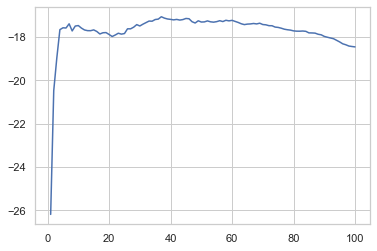

In [50]:
print('Изменение качества тестовой выборки в зависимости от кол-ва соседей:\n')
plt.plot(n_range, gs.cv_results_['mean_test_score'])

### 5.2. GridSearch через коэффициент детерминации

Лучшая модель:

 KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=37, p=2,
                    weights='uniform')

Лучшее число ближайших соседей:

 {'n_neighbors': 37}

Лучшее значение коэффициента детерминации:

 0.711677656331284

Изменение качества тестовой выборки в зависимости от кол-ва соседей:



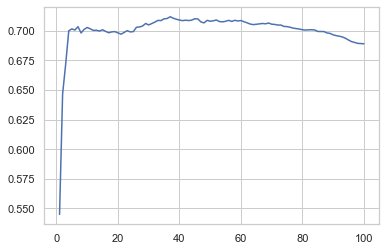

In [52]:
gs_det = GridSearchCV(KNeighborsRegressor(), tuned_parameters, cv=10, scoring='r2')
gs_det.fit(X_train, Y_train)
print('Лучшая модель:\n\n',                               gs_det.best_estimator_)
print('\nЛучшее число ближайших соседей:\n\n',            gs_det.best_params_)
print('\nЛучшее значение коэффициента детерминации:\n\n', gs_det.best_score_)

print('\nИзменение качества тестовой выборки в зависимости от кол-ва соседей:\n')
plt.plot(n_range, gs_det.cv_results_['mean_test_score'])

Запуск GridSearch проводился несколько раз

37 соседей это слишком много для точного решения задачи регрессии

Из всех полученных данных можно сделать вывод, что для качественного предсказания расхода топлива на основе других технических параметров требуется намного больший размер обучающей выборки, чем был предоставлен

## 6. Кривая обучения

Импортируем класс learning_curve из sklearn для построения кривой обучения

In [53]:
from sklearn.model_selection import learning_curve

In [58]:
def plot_learning_curve(estimator, title, X, Y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Кол-во записей")
    plt.ylabel("Оценка")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, Y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std  (train_scores, axis=1)
    test_scores_mean = np.mean (test_scores,  axis=1)
    test_scores_std = np.std   (test_scores,  axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.3, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,   test_scores_mean + test_scores_std, alpha=0.1,   color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Оценка обучающей выборки")
    plt.plot(train_sizes, test_scores_mean,  'o-', color="g", label = "Оценка кросс-валидации")

    plt.legend(loc = "best")
    return plt

<module 'matplotlib.pyplot' from 'D:\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

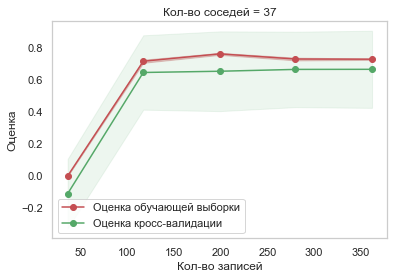

In [59]:
plot_learning_curve(KNeighborsRegressor(n_neighbors=36), 'Кол-во соседей = 37', X_train, Y_train, cv=40)

Видно, что при увеличении кол-ва записей обучение проводится все лучше и лучше. Еще раз делается вывод о том, что для хорошего обучения не хватает кол-ва записей.

## 7. Кривая валидации

Импортируем класс validation_curve из sklearn для построения кривой валидации

In [60]:
from sklearn.model_selection import validation_curve

In [65]:
def plot_validation_curve(estimator, title, X, Y, param_name, param_range, cv, scoring="accuracy"):
                                                   
    train_scores, test_scores = validation_curve(
        estimator, X, Y, param_name=param_name, param_range=param_range,
        cv=cv, scoring=scoring, n_jobs=1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.title(title)
    plt.xlabel("Количество соседей")
    plt.ylabel(str(scoring))
    plt.ylim(0.0, 1.1)
    lw = 2
    plt.plot(param_range, train_scores_mean, label="Оценка обучения", color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.4, color="darkorange", lw=lw)
    plt.plot(param_range, test_scores_mean, label="Оценка кросс-валидации", color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2, color="navy", lw=lw)
    plt.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from 'D:\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

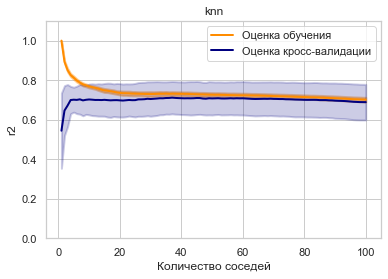

In [66]:
plot_validation_curve(KNeighborsRegressor(), 'knn', X_train, Y_train, param_name='n_neighbors', param_range=n_range, cv=10, scoring="r2")

Резкого спада оценки при увеличении количества соседей нет.

Проверим то же самое на средней квадратичной ошибке. Для этого потребуется немного поменять функцию построения графика, т.к. в данном случае вычисляется отрицательное значение средней квадратичной ошибки.

In [67]:
def plot_validation_curve2(estimator, title, X, y, param_name, param_range, cv, scoring="accuracy"):
                                                   
    train_scores, test_scores = validation_curve(estimator, X, y, param_name=param_name, param_range=param_range, cv=cv, scoring=scoring, n_jobs=1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.title(title)
    plt.xlabel("Количество соседей")
    plt.ylabel(str(scoring))
    plt.ylim(-50, 0)
    lw = 2
    plt.plot(param_range, train_scores_mean, label="Оценка обучения", color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.4, color="darkorange", lw=lw)
    plt.plot(param_range, test_scores_mean, label="Оценка кросс-валидации", color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2, color="navy", lw=lw)
    plt.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from 'D:\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

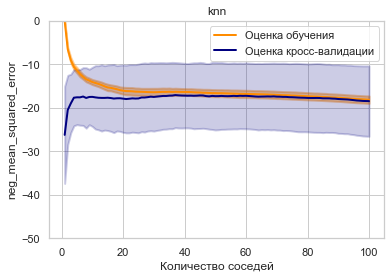

In [68]:
plot_validation_curve2(KNeighborsRegressor(), 'knn', X_train, Y_train, param_name='n_neighbors', param_range=n_range, cv=10, scoring="neg_mean_squared_error")

Также резкого спада оценки нет. Все же для хорошего обучения недостаточно данных...

## Вывод:

При выполнении лабораторной работы подбирались различные размеры тестовой и обучающей выборки. Качество обучения никогда не менялось в лучшую сторону. Коэффициент детерминации всегда держался около 0.7. Другие оценки также варьировались несильно.